Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertForSequenceClassification LOAD REPORT from: bert-base-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.bias     | MISSING    | 
pre_classifier.weight   | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Loading weights:   0%|          | 0/197 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: roberta-base
Key                             | Status     | 
--------------------------------+------------+-
lm_head.layer_norm.weight       | UNEXPECTED | 
roberta.embeddings.position_ids | UNEXPECTED | 
lm_head.dense.bias              | UNEXPECTED | 
lm_head.dense.weight            | UNEXPECTED | 
lm_head.layer_norm.bias         | UNEXPECTED | 
lm_head.bias                    | UNEXPECTED | 
classifier.out_proj.bias        | MISSING    | 
classifier.dense.weight         | MISSING    | 
classifier.dense.bias           | MISSING    | 
classifier.out_proj.weight      | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


Loading weights:   0%|          | 0/1111 [00:00<?, ?it/s]

MobileBertForSequenceClassification LOAD REPORT from: google/mobilebert-uncased
Key                                        | Status     | 
-------------------------------------------+------------+-
cls.predictions.decoder.weight             | UNEXPECTED | 
cls.predictions.transform.LayerNorm.weight | UNEXPECTED | 
cls.predictions.bias                       | UNEXPECTED | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED | 
cls.seq_relationship.bias                  | UNEXPECTED | 
mobilebert.embeddings.position_ids         | UNEXPECTED | 
cls.predictions.transform.dense.bias       | UNEXPECTED | 
cls.predictions.transform.dense.weight     | UNEXPECTED | 
cls.predictions.dense.weight               | UNEXPECTED | 
cls.seq_relationship.weight                | UNEXPECTED | 
cls.predictions.decoder.bias               | UNEXPECTED | 
classifier.bias                            | MISSING    | 
classifier.weight                          | MISSING    | 

Notes:
- UNEXPECTED	:can be ignore

        Model  Accuracy  Inference_Time_ms  Model_Size_MB  TOPSIS_Score  Rank
3  MobileBERT  0.500000         111.156998      93.776375      0.981106   1.0
1  DistilBERT  0.506667         157.330868     255.413094      0.695682   2.0
0        BERT  0.496667         337.312983     417.647469      0.094168   3.0
2     RoBERTa  0.500000         338.990946     475.491219      0.009536   4.0


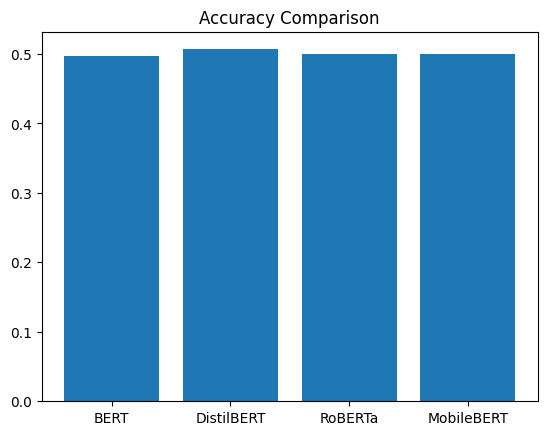

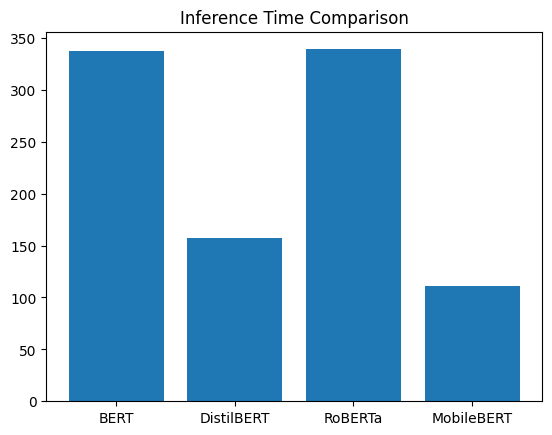

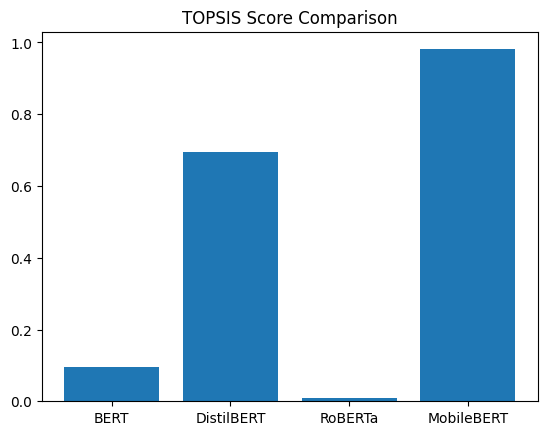

Best Pre-trained Model: MobileBERT


In [6]:
!pip install -q transformers datasets torch scikit-learn pandas matplotlib

import time
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset, concatenate_datasets   # Hugging Face
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score

device = "cuda" if torch.cuda.is_available() else "cpu"

raw = load_dataset("imdb", split="test")
pos = raw.filter(lambda x: x["label"] == 1).shuffle(seed=42).select(range(150))
neg = raw.filter(lambda x: x["label"] == 0).shuffle(seed=42).select(range(150))
dataset = concatenate_datasets([pos, neg]).shuffle(seed=42)

models = {
    "BERT": "bert-base-uncased",
    "DistilBERT": "distilbert-base-uncased",
    "RoBERTa": "roberta-base",
    "MobileBERT": "google/mobilebert-uncased"
}

results = []

for name, ckpt in models.items():
    tokenizer = AutoTokenizer.from_pretrained(ckpt)
    model = AutoModelForSequenceClassification.from_pretrained(ckpt, num_labels=2).to(device)
    model.eval()

    preds = []
    start = time.time()

    with torch.no_grad():
        for text in dataset["text"]:
            inputs = tokenizer(
                text,
                truncation=True,
                padding=True,
                max_length=128,
                return_tensors="pt"
            ).to(device)
            outputs = model(**inputs)
            preds.append(torch.argmax(outputs.logits, dim=1).item())

    inference_time = (time.time() - start) / len(dataset) * 1000
    accuracy = accuracy_score(dataset["label"], preds)
    model_size = sum(p.numel() for p in model.parameters()) * 4 / (1024**2)

    results.append([name, accuracy, inference_time, model_size])

df = pd.DataFrame(
    results,
    columns=["Model", "Accuracy", "Inference_Time_ms", "Model_Size_MB"]
)

matrix = df[["Accuracy", "Inference_Time_ms", "Model_Size_MB"]].values
weights = np.array([0.5, 0.3, 0.2])
impacts = ['+', '-', '-']

norm = matrix / np.sqrt((matrix ** 2).sum(axis=0))
weighted = norm * weights

ideal_best = np.array([weighted[:, i].max() if impacts[i] == '+' else weighted[:, i].min() for i in range(3)])
ideal_worst = np.array([weighted[:, i].min() if impacts[i] == '+' else weighted[:, i].max() for i in range(3)])

dist_best = np.sqrt(((weighted - ideal_best) ** 2).sum(axis=1))
dist_worst = np.sqrt(((weighted - ideal_worst) ** 2).sum(axis=1))

df["TOPSIS_Score"] = dist_worst / (dist_best + dist_worst)
df["Rank"] = df["TOPSIS_Score"].rank(ascending=False)

print(df.sort_values("Rank"))

plt.figure()
plt.bar(df["Model"], df["Accuracy"])
plt.title("Accuracy Comparison")
plt.show()

plt.figure()
plt.bar(df["Model"], df["Inference_Time_ms"])
plt.title("Inference Time Comparison")
plt.show()

plt.figure()
plt.bar(df["Model"], df["TOPSIS_Score"])
plt.title("TOPSIS Score Comparison")
plt.show()

print("Best Pre-trained Model:", df.sort_values("Rank").iloc[0]["Model"])
